In [1]:
import os

import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import seaborn as sns

from datetime import datetime

In [2]:
start = datetime.now()
print("start = ", start)
try:
    
    mydb = mysql.connector.connect(
        host=os.environ['MYSQL_SPOTIFY_HOST'],
        user=os.environ['MYSQL_SPOTIFY_USER'],
        password=os.environ['MYSQL_SPOTIFY_PW'],
        database="wilts_songs"
    )

    mycursor = mydb.cursor()
    mycursor.execute("""SELECT * FROM songs_full;""")

    data = mycursor.fetchall()
except mysql.connector.Error as error:
    print("Failed to insert into MySQL table {}".format(error))

finally:
    if mydb.is_connected():
        mycursor.close()
        mydb.close()
        print("MySQL connection is closed")
    end = datetime.now()
    print("finish = ", end)
    print("duration = ", (end-start).total_seconds())

start =  2022-07-07 12:09:24.926728
MySQL connection is closed
finish =  2022-07-07 12:09:25.232728
duration =  0.306


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
columns = ['id', 'track_name', 'artist_name', 'popularity', 'duration_ms',
        'danceability', 'time_signature', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo']

nominal_cols = ['id', 'track_name', 'artist_name']
discret_cols = ['key', 'mode']
continuous_cols = ['popularity', 'duration_ms', 'danceability', 'time_signature', 'energy', 'loudness', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo'] 
useful_cols = discret_cols + continuous_cols

In [5]:
df = pd.DataFrame(data, columns=columns)

In [6]:
df.describe()

,popularity,duration_ms,danceability,time_signature,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,61116.000000,6.111600e+04,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.000000,61116.00000
mean,42.683536,2.362429e+05,0.562745,3.905622,0.592023,5.241361,-9.759729,0.700373,0.072762,0.328216,0.127186,0.202740,0.556389,120.58324
std,20.443069,1.395302e+05,0.168019,0.385231,0.243643,3.531235,4.644889,0.458098,0.084394,0.320412,0.276436,0.177193,0.257077,29.00575
min,0.000000,1.200000e+04,0.000000,0.000000,0.000020,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,33.000000,1.762270e+05,0.449000,4.000000,0.416000,2.000000,-12.224000,0.000000,0.033300,0.030700,0.000000,0.093100,0.351000,98.03300
50%,44.000000,2.197070e+05,0.570000,4.000000,0.609000,5.000000,-8.968000,1.000000,0.043000,0.216000,0.000106,0.130000,0.569000,119.86500
75%,57.000000,2.708670e+05,0.684000,4.000000,0.793000,8.000000,-6.430000,1.000000,0.068200,0.600000,0.027025,0.261000,0.773000,137.81125
max,100.000000,4.800118e+06,0.988000,5.000000,1.000000,11.000000,3.744000,1.000000,0.961000,0.996000,1.000000,0.997000,0.994000,243.37200


We will have to scale the datas to have all of them approximately at the same scale for the distance calculated to be relevant. 
The nominal cols (id, track_name and artist_name) won't be used for the model, they are simply kept to know which songs the data refers to. 

## Checking the distribution 

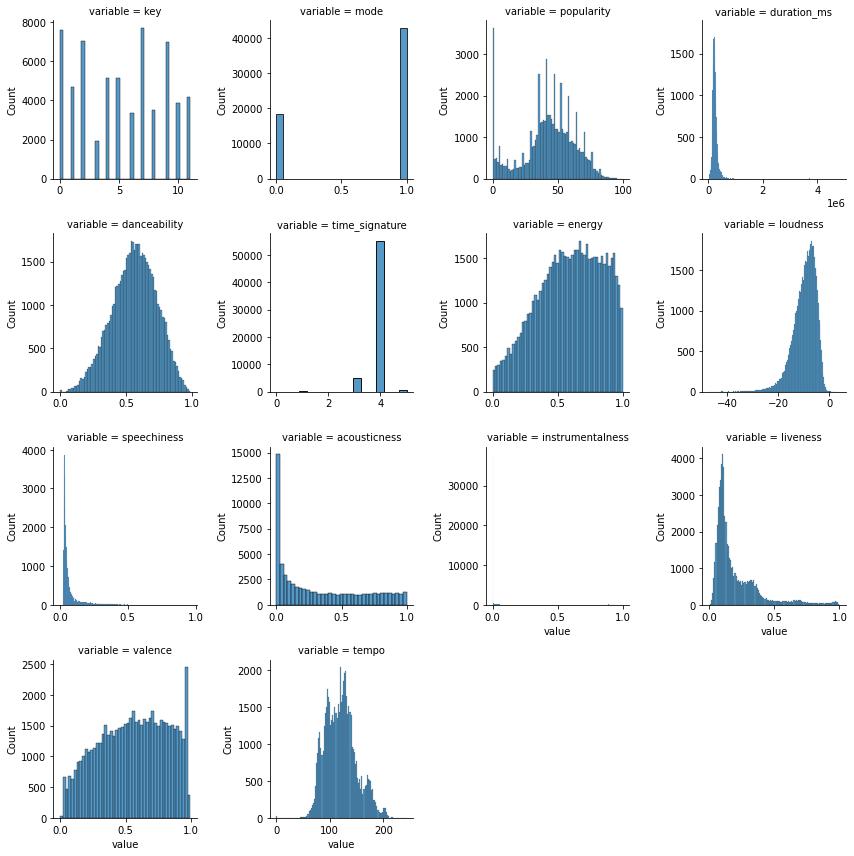

In [7]:
# Grid of distribution plots of all numerical features
f = pd.melt(df[useful_cols])
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value')

time_signature seems to have mainly one value. 
duration_ms, speechiness and instrumentalness seems to have outliers that we may need to deal with.
The remaining values seem to be usable. 

RETIRER UN %AGE ? => A voir suivant ce que le modèle donne (si les valeurs extrêmes sont vraiment éloignées du reste des clusters)

In [8]:
(df.speechiness >= 0.5).sum()/df.speechiness.shape[0]*100

0.4614176320439819

In [9]:
df.speechiness.quantile(q=0.95)

0.253

In [10]:
df.speechiness.quantile(q=0.99)

0.422

In [11]:
df.instrumentalness.quantile(q=0.8)

0.0985

In [12]:
df.instrumentalness.quantile(q=0.95)

0.876

In [13]:
df.duration_ms.quantile(q=0.95)

397560.0

## Checking what is the percentage of the most used value

In [14]:
sparsity = pd.DataFrame()

sparsity['Value'] = df[useful_cols].apply(lambda column: column.mode().values[0])
sparsity['Percentage of value'] = df.apply(lambda column: round(column[column == column.mode().values[0]].count()/column.shape[0]*100,2))
sparsity.sort_values(by="Percentage of value", ascending=False)

,Value,Percentage of value
time_signature,4.0000,90.08
mode,1.0000,70.04
instrumentalness,0.0000,28.09
key,7.0000,12.61
popularity,0.0000,5.26
liveness,0.1110,0.94
valence,0.9610,0.54
speechiness,0.0324,0.40
danceability,0.5510,0.27
energy,0.4490,0.18


time_signature has the value 4 in more than 90% of the time. But the value may be relevant for the clustering because it's an important feature in music, so I will keep it until we can check with the model if it's better to keep it or not. 

## Visualisation de la corrélation entre les variables

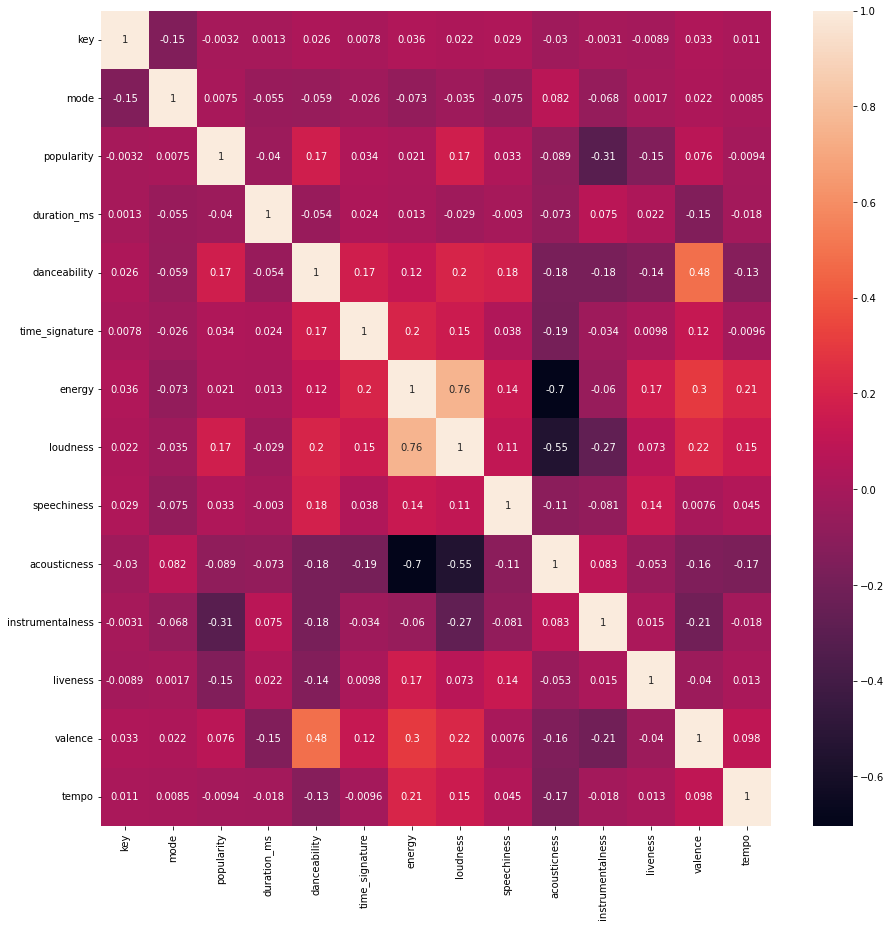

In [15]:
ax=sns.heatmap(df[useful_cols].corr(), xticklabels=True, yticklabels=True, annot=True)
fig = plt.gcf()
# Modifie la taille du graphique
fig.set_size_inches(15,15)

In [16]:
df[useful_cols].corr()

,key,mode,popularity,duration_ms,danceability,time_signature,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
key,1.000000,-0.145921,-0.003176,0.001338,0.025578,0.007784,0.036498,0.021923,0.029063,-0.030132,-0.003072,-0.008919,0.032934,0.011176
mode,-0.145921,1.000000,0.007527,-0.055176,-0.059096,-0.026263,-0.073215,-0.035027,-0.074610,0.081714,-0.067951,0.001694,0.022462,0.008484
popularity,-0.003176,0.007527,1.000000,-0.039569,0.174377,0.033581,0.020725,0.170909,0.033347,-0.088743,-0.314158,-0.148547,0.075689,-0.009414
duration_ms,0.001338,-0.055176,-0.039569,1.000000,-0.053819,0.024254,0.013263,-0.028813,-0.003012,-0.072525,0.075095,0.021911,-0.150102,-0.017526
danceability,0.025578,-0.059096,0.174377,-0.053819,1.000000,0.172296,0.117347,0.202179,0.182378,-0.180751,-0.182715,-0.141409,0.482544,-0.126946
time_signature,0.007784,-0.026263,0.033581,0.024254,0.172296,1.000000,0.203054,0.149929,0.038418,-0.187574,-0.033587,0.009801,0.122950,-0.009558
energy,0.036498,-0.073215,0.020725,0.013263,0.117347,0.203054,1.000000,0.756668,0.140878,-0.703485,-0.059931,0.165849,0.295277,0.208527
loudness,0.021923,-0.035027,0.170909,-0.028813,0.202179,0.149929,0.756668,1.000000,0.105894,-0.547220,-0.274621,0.072726,0.219896,0.152658
speechiness,0.029063,-0.074610,0.033347,-0.003012,0.182378,0.038418,0.140878,0.105894,1.000000,-0.105701,-0.080665,0.138915,0.007562,0.044582
acousticness,-0.030132,0.081714,-0.088743,-0.072525,-0.180751,-0.187574,-0.703485,-0.547220,-0.105701,1.000000,0.083436,-0.052689,-0.155397,-0.165179


There is a rather high correlation between acousticness, energy and loudness especially the energy with the other 2.

In [17]:
corr_col = ['acousticness', 'energy', 'loudness']
df_corr = df[corr_col]
df_corr.corr()

,acousticness,energy,loudness
acousticness,1.000000,-0.703485,-0.547220
energy,-0.703485,1.000000,0.756668
loudness,-0.547220,0.756668,1.000000


In [18]:
df_corr['acousticness/energy']=df_corr['acousticness']/df_corr['energy']
df_corr['loudness/energy']=-df_corr['loudness']/df_corr['energy']
#LE MIEUX (car directement compris entre 0 et 1 et décorrelé avec loudness)
df_corr['acousticness*energy']=df_corr['acousticness']*df_corr['energy']
df_corr['loudness*energy']=-df_corr['loudness']*df_corr['energy']

/tmp/ipykernel_20333/696442939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['acousticness/energy']=df_corr['acousticness']/df_corr['energy']
/tmp/ipykernel_20333/696442939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['loudness/energy']=-df_corr['loudness']/df_corr['energy']
/tmp/ipykernel_20333/696442939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [19]:
from numpy import log
df_corr['acousticness/energy2']=df_corr['acousticness/energy'].apply(lambda x: log(1+x)/x)
df_corr['loudness/energy2']=df_corr['loudness/energy'].apply(lambda x: log(1+x)/x)
df_corr['acousticness*energy2']=df_corr['acousticness*energy'].apply(lambda x: log(1+x)/x)
df_corr['loudness*energy2']=df_corr['loudness*energy'].apply(lambda x: log(1+x)/x)

/tmp/ipykernel_20333/2627893963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['acousticness/energy2']=df_corr['acousticness/energy'].apply(lambda x: log(1+x)/x)
/tmp/ipykernel_20333/2627893963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['loudness/energy2']=df_corr['loudness/energy'].apply(lambda x: log(1+x)/x)
/tmp/ipykernel_20333/2627893963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [20]:
df_corr.corr()

,acousticness,energy,loudness,acousticness/energy,loudness/energy,acousticness*energy,loudness*energy,acousticness/energy2,loudness/energy2,acousticness*energy2,loudness*energy2
acousticness,1.000000,-0.703485,-0.547220,0.023734,0.008541,0.712300,-0.359027,-0.946167,-0.598854,-0.732204,0.398544
energy,-0.703485,1.000000,0.756668,-0.029708,-0.030882,-0.185749,0.442666,0.829611,0.872834,0.221913,-0.475293
loudness,-0.547220,0.756668,1.000000,-0.056718,-0.048385,-0.059934,-0.040930,0.688245,0.853442,0.079635,-0.140579
acousticness/energy,0.023734,-0.029708,-0.056718,1.000000,0.805982,-0.007770,-0.028551,-0.041146,-0.023362,0.008303,0.065513
loudness/energy,0.008541,-0.030882,-0.048385,0.805982,1.000000,-0.011931,-0.031477,-0.037785,-0.024189,0.011223,0.079230
acousticness*energy,0.712300,-0.185749,-0.059934,-0.007770,-0.011931,1.000000,-0.010866,-0.483266,-0.173106,-0.995860,-0.036640
loudness*energy,-0.359027,0.442666,-0.040930,-0.028551,-0.031477,-0.010866,1.000000,0.461470,0.008103,0.029104,-0.901719
acousticness/energy2,-0.946167,0.829611,0.688245,-0.041146,-0.037785,-0.483266,0.461470,1.000000,0.699373,0.512403,-0.544526
loudness/energy2,-0.598854,0.872834,0.853442,-0.023362,-0.024189,-0.173106,0.008103,0.699373,1.000000,0.202737,-0.060785
acousticness*energy2,-0.732204,0.221913,0.079635,0.008303,0.011223,-0.995860,0.029104,0.512403,0.202737,1.000000,0.023729


In [21]:
df_corr.describe()

,acousticness,energy,loudness,acousticness/energy,loudness/energy,acousticness*energy,loudness*energy,acousticness/energy2,loudness/energy2,acousticness*energy2,loudness*energy2
count,61116.000000,61116.000000,61116.000000,61116.000000,6.111600e+04,61116.000000,61116.000000,61109.000000,61112.000000,61109.000000,61112.000000
mean,0.328216,0.592023,-9.759729,3.062158,1.609340e+02,0.139394,4.921681,0.785656,0.197476,0.940422,0.381515
std,0.320412,0.243643,4.644889,205.118546,1.136567e+04,0.135810,1.887428,0.220357,0.105006,0.053584,0.090036
min,0.000000,0.000020,-47.070000,0.000000,-3.755266e+00,0.000000,-3.732768,0.000231,0.000007,0.699349,0.124175
25%,0.030700,0.416000,-12.224000,0.043555,8.464217e+00,0.019800,3.636888,0.645056,0.120338,0.902483,0.323297
50%,0.216000,0.609000,-8.968000,0.349651,1.460767e+01,0.104606,4.738499,0.857495,0.188091,0.951079,0.368721
75%,0.600000,0.793000,-6.430000,1.272453,2.796869e+01,0.223585,6.033755,0.978799,0.265520,0.990222,0.421771
max,0.996000,1.000000,3.744000,46502.463054,1.992562e+06,0.968252,26.767776,0.999999,2.550206,1.000000,2.550206
